# Facial Keypoint Detection - Define the CNN

After we've looked at the data we're working with and, in this case, know the shapes of the images and of the keypoints, we are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, we will:

- [Step 1](#step1): Define a CNN with images as input and keypoints as output
- [Step 2](#step2): Construct the transformed FaceKeypointsDataset, just as before
- [Step 3](#step3): Visualize some sample outputs before training the CNN
- [Step 4](#step4): Train the CNN on the training data, tracking and visualizing losses
- [Step 5](#step5): See how the trained model performs on test data
- [Step 6](#step6): Visualize the effect of a convolutional kernel on an image

<a id=step1></a>
## CNN Architecture

The CNN which is called `Net` and defined in `models.py` consists of a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers
* Dropout layers

This was our initial network:
```python
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=1)
        # maxpool that uses a square window of kernel_size=2, stride=2
        self.pool = nn.MaxPool2d(2, 2)
        # Dropout layers
        self.dropout = nn.Dropout(0.2)
        # Fully-connected layers
        self.fc1 = nn.Linear(64 * 54 * 54, 512)
        self.fc2 = nn.Linear(512, 136)              
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 64 * 54 * 54)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)            
        return x
```
Below are the steps we took to update the network and tune the hyparameters:

* We decided to use 3 pairs of convolutional and max pooling layers. We can certainly increase the number of pairs, as seen in [this paper](https://arxiv.org/pdf/1710.00977.pdf), but it will take more time to train.

* Kernel size: We tried 2, 3, 4 and 5. Higher sizes required more time for training and the average loss didn't improve. Therefore we chose the kernel size of 5.

* Dropout: There were two things that worked well: (1) adding a dropout after each pair of convolutional and max pooling layers, and after the 2nd last fully-connected layer, and (2) increasing the dropout values as the network got deeper.

With these changes, we came up with the final model as seen in `models.py`. There are opportunities for further improvement: increasing the number of convo/maxpooling pairs, adding batch normalization, initializing weights, preserving the output size after each convo layer, etc.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

# import the CNN class and instantiate a model
from models import Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2)
  (dropout2): Dropout(p=0.3)
  (dropout3): Dropout(p=0.4)
  (fc1): Linear(in_features=86528, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=136, bias=True)
)


<a id=step2></a>
## Transform the dataset 

To prepare for training, we will create a transformed dataset of images and keypoints. In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so our model's loss does not blow up during training, we should normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py`.

To define the data transform below, we use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that we are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

Other data augmentation steps include randomly rotating or shifting these images.

In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from data_load import FacialKeypointsDataset
from data_load import Rescale, RandomCrop, Normalize, ToTensor

# define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(256), RandomCrop(224), Normalize(), ToTensor()])

# testing that we've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [3]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size, sample['keypoints'].size)

Number of images:  3462
0 <built-in method size of Tensor object at 0x7fbf23b1ec18> <built-in method size of Tensor object at 0x7fbf23b1ec60>
1 <built-in method size of Tensor object at 0x7fbf23b1ee10> <built-in method size of Tensor object at 0x7fbf23b1eea0>
2 <built-in method size of Tensor object at 0x7fbf23b1ec60> <built-in method size of Tensor object at 0x7fbf23b1ef30>
3 <built-in method size of Tensor object at 0x7fbf23b1eea0> <built-in method size of Tensor object at 0x7fbf23b37048>


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's [DataLoader class](http://pytorch.org/docs/master/data.html) to load the training data in batches of whatever size as well as to shuffle the data for training the model. We use a batch size of 32 for this project. 

First, let's split the data into training and validation sets.

In [4]:
from torch.utils.data.sampler import SubsetRandomSampler
# Keep 80% of the transformed_dataset as training data
percent_train = 0.8
n_training_samples = len(transformed_dataset) * percent_train
train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, len(transformed_dataset), dtype=np.int64))

In [5]:
# load training and validation data in batches
batch_size = 32

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          sampler=train_sampler,
                          num_workers=4)

val_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          sampler=val_sampler,
                          num_workers=4)

<a id=step3></a>
## Before training

We will a look at how this model performs before it trains. We should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that we can compare it to the model after training and see how the model has improved.

### Load in the test dataset

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [6]:
# load in the test data, using the dataset class and apply data_transform defined above
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)

In [7]:
# load test data in batches
batch_size = 32

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

### Apply the model on a test sample

To test the model on a test sample of data, we will:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [8]:
# test the model on a batch of test images
def net_sample_output():
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']
        
        # wrap images in a torch Variable
        # key_pts do not need to be wrapped until they are used for training
        images = Variable(images)

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

In [9]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


### Visualize the predicted keypoints

The function `show_all_keypoints` displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [10]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


`visualize_output` takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data, transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform.

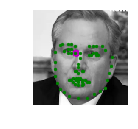

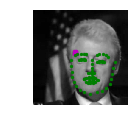

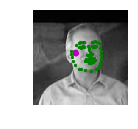

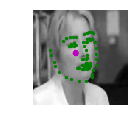

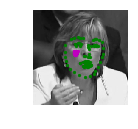

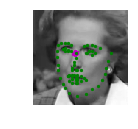

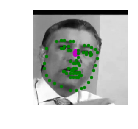

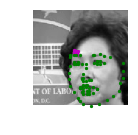

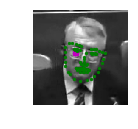

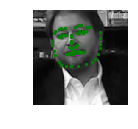

In [11]:
# visualize the output; by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

<a id=step4></a>
## Training

### Loss function and optimizer

Training a network to predict keypoints is a regression problem. So we will choose a loss function that is suited for regression, which directly compares a predicted value and target value. We will use `MSELoss`. Mean squared error is a common loss function for regression problems. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

We will use Adam. According to [this](http://cs231n.github.io/neural-networks-3/#update), Adam is recommended as the default algorithm and often works slightly better than RMSProp. 

In [13]:
# Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

### Early stopping
We will define `early_stopping` which stops training when the validation losses do not improve for 10 consecutive epochs. 
  * Earlier in this notebook we split training set into train and validation sets using `SubsetRandomSampler`. This is important because `early_stopping` is supposed to check for changes in validation losses (not training losses).
  * In the `train_net` function, we will let the network train for at least 20 epochs before checking if the validation losses no longer improve for 10 consecutive epochs. 

In [14]:
def early_stopping(val_losses, patience=10):
    """Check if the validation losses no longer improve for 10 
    (or a specified number of) consecutive epochs."""
    # The number of epochs should be at least patience before checking
    # for convergence
    if patience > len(val_losses):
        return False
    latest_losses = val_losses[-patience:]
    # If all the latest losses are the same, return True
    if len(set(latest_losses)) == 1:
        return True
    min_loss = min(val_losses)
    if min_loss in latest_losses:
        # If one of recent losses improves, not yet converged
        if min_loss not in val_losses[:len(val_losses) - patience]:
            return False
        else:
            return True
    # If none of recent losses is lower than min_loss, it has converged
    return True

### Train the network
We will define a function called `train_net` which will load in data in batches, keep track of and print out losses, and save the best model.

In [15]:
# Specify a model name and path to save the model whenever validation loss improves
model_dir = 'saved_models/'
model_name = 'my_model_save_best.pt'

def train_net(n_epochs):
    # prepare the net for training
    net.train()
    # Keep track of training and validation losses
    train_losses = []
    val_losses = []
    # Keep track of the current best validation loss and save the model 
    # when an epoch's validation loss is better than best_val_loss
    best_val_loss = float("INF")

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        print ("Epoch {}/{}".format(epoch + 1, n_epochs))
        running_loss = 0.0
        start_time = time.time()
        total_train_loss = 0

        # train on batches of data
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)
            
            # wrap them in a torch Variable
            images, key_pts = Variable(images), Variable(key_pts)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.data[0]
            total_train_loss += loss.data[0]
            if batch_i % 10 == 9:    # print every 10 batches
                #print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0
        # Record the training loss for each epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Now check and record the loss for the validation set
        total_val_loss = 0
        for batch_i, data in enumerate(val_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)
            
            # wrap them in a torch Variable
            images, key_pts = Variable(images), Variable(key_pts)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)
            
            # record loss
            total_val_loss += loss.data[0]
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        if avg_val_loss < best_val_loss:
            torch.save(net.state_dict(), model_dir + model_name)
            print ("    val_loss improved from {} to {}, saving model to {}".format(best_val_loss, 
                                                                                    avg_val_loss, 
                                                                                    model_name))
            best_val_loss = avg_val_loss
        else:
            print ("    val_loss did not improve")
        print ("    took {:.2f}s; loss = {:.2f}; val_loss = {:.2f}".format(time.time() - start_time, 
                                                                           avg_train_loss, 
                                                                           avg_val_loss))
        # Train for at least 20 epochs before checking for early_stopping
        if epoch > 50:
                # Stop if the validation loss doesn't improve for 15 epochs
            if early_stopping(val_losses, 15):
                break

    print('Finished Training')
    # Return train and validation losses for visualization
    return train_losses, val_losses

In [16]:
# train our network
n_epochs = 150

train_losses, val_losses = train_net(n_epochs)

Epoch 1/150
Epoch 0001: val_loss improved from inf to 0.22695448926903986, saving model to my_model_save_best.pt
    took 489.69s; loss = 0.34; val_loss = 0.23
Epoch 2/150
Epoch 0002: val_loss improved from 0.22695448926903986 to 0.22155100174925543, saving model to my_model_save_best.pt
    took 501.82s; loss = 0.21; val_loss = 0.22
Epoch 3/150
Epoch 0003: val_loss improved from 0.22155100174925543 to 0.2088115489618345, saving model to my_model_save_best.pt
    took 478.85s; loss = 0.19; val_loss = 0.21
Epoch 4/150
Epoch 0004: val_loss improved from 0.2088115489618345 to 0.2045119418339296, saving model to my_model_save_best.pt
    took 491.50s; loss = 0.18; val_loss = 0.20
Epoch 5/150
Epoch 0005: val_loss improved from 0.2045119418339296 to 0.18661701001904227, saving model to my_model_save_best.pt
    took 488.94s; loss = 0.18; val_loss = 0.19
Epoch 6/150
Epoch 0006: val_loss improved from 0.18661701001904227 to 0.17613313076171008, saving model to my_model_save_best.pt
    took 48

### Visualize the training and validation losses

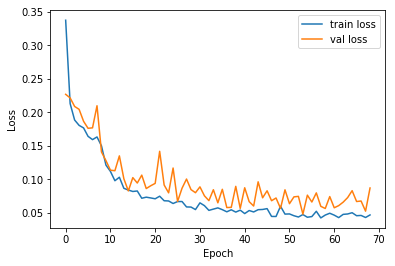

In [17]:
# Visualize the training and validation losses of the neural network
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train loss', 'val loss'])
plt.show()

<a id=step5></a>
## Test data

See how our model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, we will run our trained model on these images to see what kind of keypoints are produced.

In [18]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


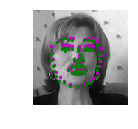

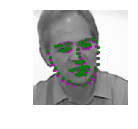

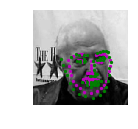

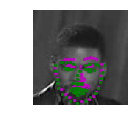

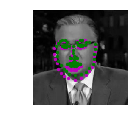

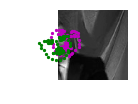

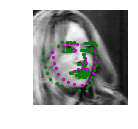

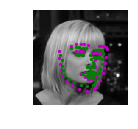

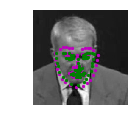

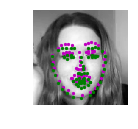

In [19]:
# visualize test output
visualize_output(test_images, test_outputs, gt_pts, batch_size=10)

Our model performs relatively well!

<a id=step6></a>
## Feature Visualization

Sometimes, neural networks are thought of as a black box. Given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and we can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

### Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, we might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. We can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, we might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


### Extract a filter

In the cell below, we can see how to extract a single filter (by index) from our first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.02054536  0.05099834 -0.13234222 -0.15845524 -0.0516724 ]
 [ 0.12439179 -0.25704345 -0.11763806 -0.09507624  0.01358026]
 [-0.14743468  0.07140829  0.10368631  0.05692802  0.12806046]
 [-0.07507723 -0.04579978 -0.13371663  0.15213424  0.19091861]
 [-0.08720697 -0.02502332 -0.07308009  0.10155448  0.25697386]]
(5, 5)


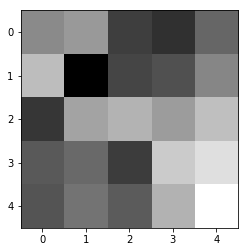

In [35]:
# Get the weights in the first conv layer, "conv1"
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 7

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')

### Filter an image to see the effect of a convolutional kernel

Next, we will choose a test image and filter it with one of the convolutional kernels in our trained CNN.

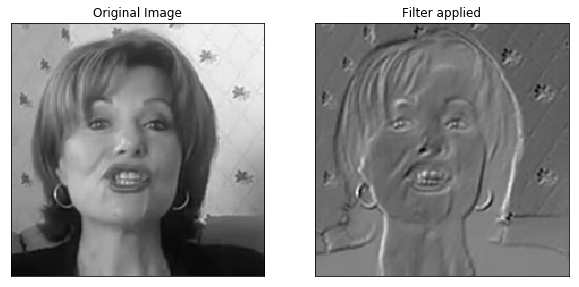

In [40]:
import cv2

image = test_images[0].data
image = image.numpy()   # convert to numpy array from a Tensor
image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
image = np.squeeze(image)

# Apply conv1's kernel weights the test image
kernel = w[filter_index][0]
filtered_image = cv2.filter2D(image,-1,kernel)

# Plot the RGB and edge-detected image
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(121)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Original Image')
ax1.imshow(image, cmap="gray")

ax2 = fig.add_subplot(122)
ax2.set_xticks([])
ax2.set_yticks([])

ax2.set_title('Filter applied')
ax2.imshow(filtered_image, cmap='gray')

The above filter detects edges.

## Moving on!

In the next notebook **Facial Keypoint Detection** we will combine a face detector with our saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!